In [1]:
import torch
from src.modules.encoder import Encoder
from src.modules.decoder import Model
from src.modules.dataset import FlickrDataset, Collate
from src.modules.attention import CausalAttention, CrossAttention
from torch.utils.data import DataLoader
from tqdm import tqdm
import plotly.express as px
import plotly.io as pio
import torchvision.transforms as T

pio.renderers.default = 'png'

In [2]:
batch_size = 8
imgs_path = '/mnt/s/CV/data/Images'
captions_path = '/mnt/s/CV/data/captions.txt'
dataset = FlickrDataset(imgs_path, captions_path)
collate = Collate(pad_idx=dataset.vocab.word2idx['<PAD>'])
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate)
vocab_size = len(dataset.vocab)
vocab = dataset.vocab

In [3]:
decoder_config = dict(
    num_layers=6,
    vocab_size=vocab_size,
    d_model=512,
    dff=2048,
    num_heads=8
)
model = Model(**decoder_config).cuda()


In [4]:
img_batch, cap_batch = next(iter(dataloader))
img_batch = img_batch.cuda()
cap_batch = cap_batch.cuda()
preds = model(img_batch, cap_batch)
preds.shape

torch.Size([8, 18, 4111])

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = T.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)

In [6]:
preds = model.caption_image(img_batch[0])
preds = [vocab.idx2word[idx] for idx in preds]
# preds

Epoch: 1


100%|██████████| 5057/5057 [09:07<00:00,  9.24it/s]


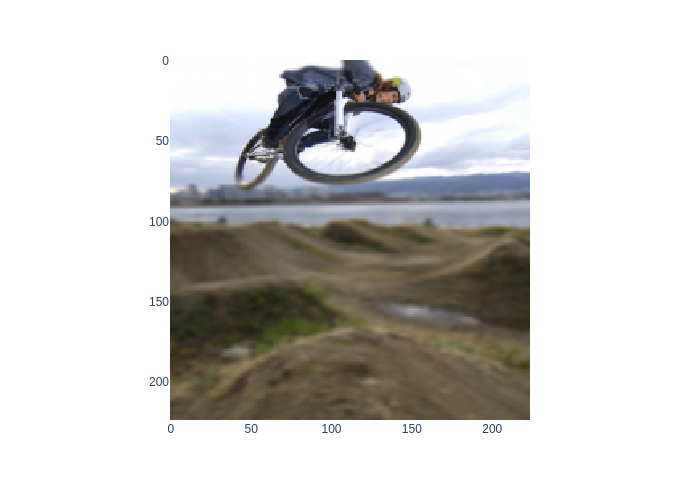

<SOS> a man is riding a bike . <EOS>
Loss: 2.802



In [7]:
lr = 1e-4
num_epochs = 1
optimizer = torch.optim.Adam(
    params=model.parameters(), 
    lr=lr
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>']).cuda()

for epoch in range(1, num_epochs+1):
    print(f'Epoch: {epoch}')
    for i, (imgs, captions) in enumerate(tqdm(dataloader), start=1):
        imgs = imgs.cuda()
        captions: torch.Tensor = captions.cuda()
        captions_input = captions[:, :-1]
        captions_expected = captions[:, 1:]
        optimizer.zero_grad()
        outputs: torch.Tensor = model(
            imgs,
            captions_input
        )
        loss: torch.Tensor = criterion(
            outputs.contiguous().view(-1, vocab_size),
            captions_expected.contiguous().view(-1)
        )
        loss.backward()
        optimizer.step()
    px.imshow(inv_normalize(imgs[0].cpu()).permute(1, 2, 0)).show()
    preds = model.caption_image(imgs[0])
    preds = [vocab.idx2word[idx] for idx in preds]
    print(' '.join(preds))
    print('Loss:', round(loss.item(), 3))
    print()

torch.save(model.state_dict(), 'weights.pt')

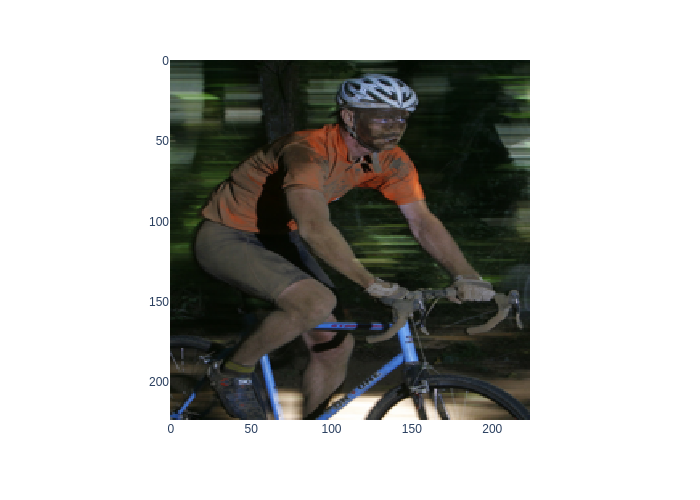

['<SOS>',
 'a',
 'man',
 'in',
 'a',
 'red',
 'shirt',
 'is',
 'standing',
 'in',
 'the',
 'snow',
 '.',
 '<EOS>']

In [15]:
img_batch, cap_batch = next(iter(dataloader))
img = img_batch[0].cuda()
cap = cap_batch[0].cuda()
idx = 1
px.imshow(inv_normalize(img.cpu()).permute(1, 2, 0)).show()
[vocab.idx2word[idx] for idx in model.caption_image(img)]